# Week 1 Seminar

A/B experiment analysis

In [39]:
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

pd.set_option("display.precision", 3)

%matplotlib inline

In [52]:
# зададим эксп-т, с которым мы работали
experiment = "HW"  # "PERSONALIZED"

In [53]:
# путь к логам контейнера
exp_folder = "experiments/hw_weighted/data.json"  # 2000 episodes
data_path = "/Users/giyuu/study/made22/2nd-semester/recommendation/log/" + exp_folder

In [54]:
data = pd.read_json(data_path, lines=True)
# в поле treatment запишем название группы, в которую попал пользователь
data["treatment"] = data["experiments"].map(lambda experiments: experiments[experiment])

In [55]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,treatment
0,next,2023-04-10 18:46:38.491,3255,2659,1.00,4.309e-03,7714.0,{'HW': 'C'},C
1,next,2023-04-10 18:46:38.520,3255,7714,0.99,4.301e-04,2791.0,{'HW': 'C'},C
2,next,2023-04-10 18:46:38.526,3255,2791,0.85,4.461e-04,7635.0,{'HW': 'C'},C
3,next,2023-04-10 18:46:38.533,3255,7635,0.80,4.737e-04,407.0,{'HW': 'C'},C
4,next,2023-04-10 18:46:38.540,3255,407,0.98,3.583e-04,16504.0,{'HW': 'C'},C


## Visualize sessions

In [56]:
# разбиваем данные по сессиям
Session = namedtuple("Session", ["timestamp", "tracks", "time", "latency"])

def sessionize(user_data):
    sessions = []  # список сессий
    session = None
    for _, row in user_data.sort_values("timestamp").iterrows():  # пробегаем по всем строкам датасета, сортированных по времени
        if session is None:
            session = Session(row["timestamp"], 0, 0, 0)  # старт сессии
        
        session = session._replace(
            tracks = session.tracks + 1, 
            time = session.time + row["time"],
            latency = session.latency + row["latency"] * 1000,
        )  # считаем статистики, пока не дошли до last
        
        if row["message"] == "last":  # наткнулись на last -- новая сессия
            sessions.append(session._asdict())
            session = None
    return sessions

In [57]:
sessions = (
    data
    .groupby(["user", "treatment"])
    .apply(sessionize)
    .explode()
    .apply(pd.Series)
)  # группируем данные по пользователю и треатменту

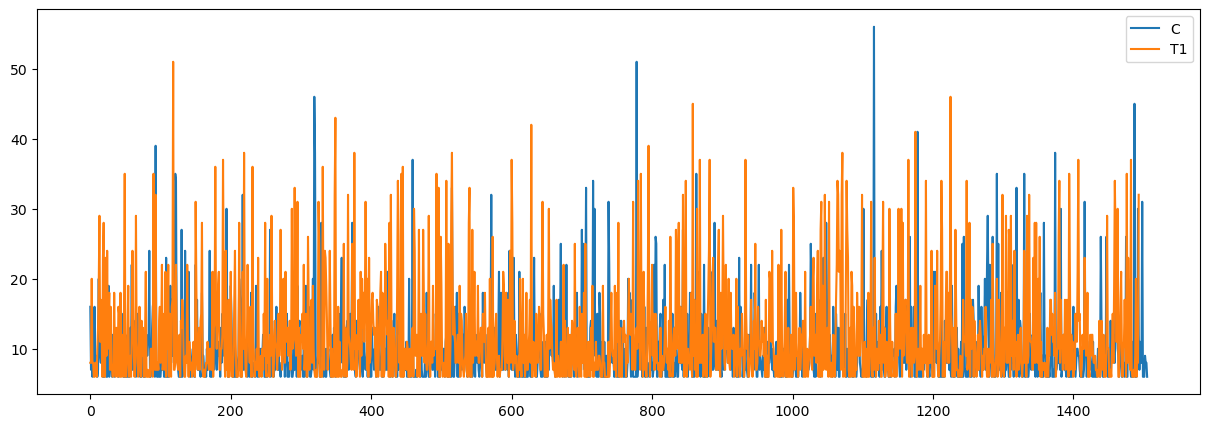

In [58]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["tracks"], label=treatment)
ax.legend()
pass  # для каждого пользователя подсчитано кол-во треков

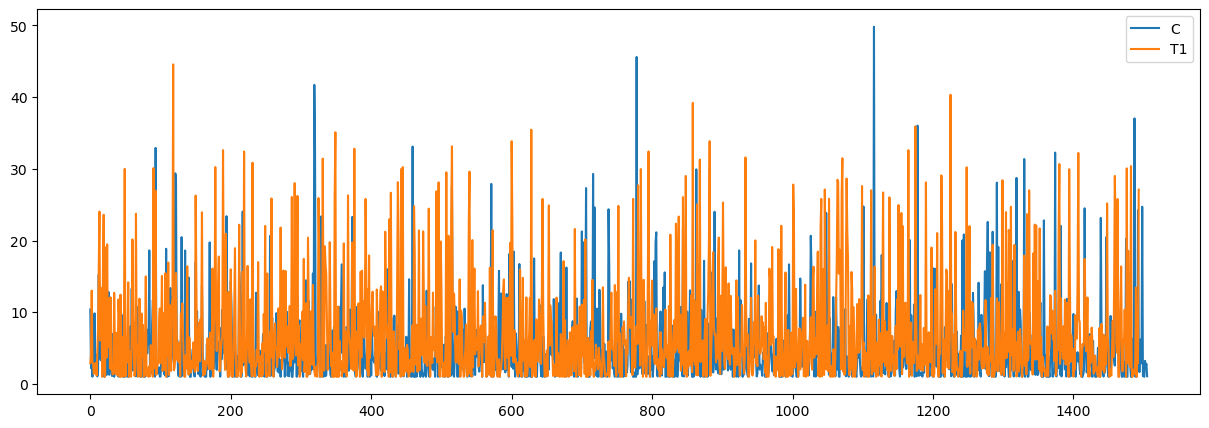

In [59]:
figure, ax = plt.subplots(figsize=(15, 5))
for treatment, treatment_sessions in sessions.groupby("treatment"):
    reindexed_treatment_sessions = treatment_sessions.sort_values("timestamp").reset_index()
    ax.plot(reindexed_treatment_sessions.index, reindexed_treatment_sessions["time"], label=treatment)
ax.legend()
pass  # такой же график для времени сессии

## Analyze the experiment

In [60]:
user_level_data = (
  sessions
    .reset_index()
    .groupby(["user", "treatment"])
    .agg(
        {
            "timestamp": "count",
            "tracks": "sum",
            "time": "sum",
            "latency": "sum"
        }
    )
)  # предобработка: аггрегируем данные по пользователю (за все его сессии) и посчитаем статистики

user_level_data["sessions"] = user_level_data["timestamp"]
user_level_data["mean_request_latency"] = user_level_data["latency"] / user_level_data["tracks"]
user_level_data["mean_tracks_per_session"] = user_level_data["tracks"] / user_level_data["sessions"]
user_level_data["mean_time_per_session"] = user_level_data["time"] / user_level_data["sessions"]

metrics = [
    "time",  # треки
    "sessions",  # сессии
    "mean_request_latency",  # средняя задержка на запрос 
    "mean_tracks_per_session",  # среднее кол-во треков на сессию
    "mean_time_per_session"  # среднее время на сессию <-- будем смотреть на нее в основном!
]  # метрики, которые анализируем

user_level_metrics = user_level_data[metrics].copy().reset_index()

In [61]:
treatment_level_metrics = (
    user_level_metrics
    .groupby("treatment")[metrics]
    .agg(["count", "mean", "var"])
)  # аггрегируем по группам пользователей

In [62]:
def dof(n_0, n_1, s2_0, s2_1):
    """
    метод подсчета степеней свободы
    """
    numerator = (s2_0 / n_0 + s2_1 / n_1) * (s2_0 / n_0 + s2_1 / n_1)
    denominator = s2_0 * s2_0 / n_0 / n_0 / (n_0 - 1) + s2_1 * s2_1 / n_1 / n_1 / (n_1 - 1)
    return numerator / denominator


def ci(n_0, n_1, s2_0, s2_1, alpha=0.05):
    """
    расчет доверительного интервала
        alpha - уровень значимости
    """
    return ss.t.ppf(1 - alpha/2, dof(n_0, n_1, s2_0, s2_1)) * np.sqrt(s2_0 / n_0 + s2_1 / n_1)


effects = []

control = [data for treatment, data in treatment_level_metrics.iterrows() if treatment == "C"][0]

for treatment, row in treatment_level_metrics.iterrows():
    """
    считаем доверительные интервалы для каждой группы
    """
    if treatment == "C":
        continue
    
    for metric in metrics:
        control_mean = control[metric]["mean"]
        treatment_mean = row[metric]["mean"]
        
        effect = treatment_mean - control_mean
        conf_int = ci(
            control[metric]["count"],
            row[metric]["count"],
            control[metric]["var"],
            row[metric]["var"],
        )
        effects.append({
            "treatment": treatment,
            "metric": metric,
            "control_mean": control_mean,
            "treatment_mean": treatment_mean,
            "effect": effect / control_mean * 100,
            "lower": (effect - conf_int) / control_mean * 100,
            "upper": (effect + conf_int) / control_mean * 100,
            "significant": (effect + conf_int) * (effect - conf_int) > 0
        })

In [63]:
def color(value):
    return 'color:red;' if value < 0 else 'color:green;'

def background(value):
    return 'color:white;background-color:green' if value else 'color:white;background-color:red'
        

(
    pd.DataFrame(effects)[[
        "treatment", 
        "metric",
        "effect",  # эффект в процентах
        "upper",  # верхняя граница доверительного интервала
        "lower",  # нижняя граница доверительного интервала
        "control_mean", 
        "treatment_mean",
        "significant"
    ]]
    .sort_values(["metric", "treatment"], ascending=False)
    .style
    .applymap(color, subset=["effect", "upper", "lower"])
    .applymap(background, subset=["significant"])  # 0 не попал в доверительный интервал
)

,treatment,metric,effect,upper,lower,control_mean,treatment_mean,significant
0,T1,time,44.152940,54.997006,33.308875,6.030482,8.693117,True
1,T1,sessions,1.940938,5.087694,-1.205818,1.189573,1.212662,False
3,T1,mean_tracks_per_session,21.562477,26.588592,16.536362,9.996775,12.152327,True
4,T1,mean_time_per_session,43.258766,53.157799,33.359732,4.993755,7.153992,True
2,T1,mean_request_latency,109.713682,114.372111,105.055253,0.398031,0.834726,True
